In [1]:
import numpy as np
import math
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
wavelength = 0.1542 #nm
lattice_constant = 0.286 #nm

In [3]:
# All of the allowed reflections for the FCC crystal structure are:
miller_indices = np.array([
    [1, 1, 0],
    [2, 0, 0],
    [2, 1, 1],
])
miller_list = [list(row) for row in miller_indices]
df = pd.DataFrame({'Miller': miller_list})

In [4]:
df['hkl_squared'] = df['Miller'].apply(lambda x: x[0]**2 + x[1]**2 + x[2]**2)
df['sin theta (rad)'] = df['hkl_squared'].apply(lambda x: math.sqrt((wavelength**2/(4*lattice_constant**2))*x))
df['theta (rad)'] = df['sin theta (rad)'].apply(lambda x:(math.asin(x)))
df['theta (deg)'] = df['theta (rad)'].apply(lambda x: np.rad2deg(x))
df['2 theta (deg)'] = df['theta (deg)'].apply(lambda x: 2 * x)

In [5]:
# Define atom positons in cubic cell:
Fe_positions = np.array([[0.0, 0.0, 0.0], [0.5, 0.5, 0.5]])

In [6]:
# This calculates the term that will be multiplied by the atomic scattering factor
# for each atom type and for each miller incices
def compute_structure_factor_term(atom_positions, miller_indices_array):
    results = {}
    
    for miller_indices in miller_indices_array:
        h, k, l = miller_indices
        total = 0
        
        for position in atom_positions:
            position_adjusted = 2*position # distribute the 2 in the exponential factor to each atom position
            x, y, z = position_adjusted
            value = x * h + y * k + z * l

            # Check if value is even or 0
            if value % 2 == 0:
                total += 1
            # If value is odd
            else:
                total -= 1
        
        # Store the result with Miller indices as the key
        results[tuple(miller_indices)] = total
    
    return results

In [7]:
Fe_structure_factor_term = compute_structure_factor_term(Fe_positions, miller_indices)
print("Al", Fe_structure_factor_term)

Al {(1, 1, 0): 2, (2, 0, 0): 2, (2, 1, 1): 2}


In [8]:
# This calculates f, the atomic scattering factor, for each atom time at each theta angle 
# check the angle calculation units
def calc_atomic_scattering_factor(theta, atomic_number, a1, b1, a2, b2, a3, b3, a4=None, b4=None, wavelength = 0.1542):
    s = math.sin(theta)/(wavelength*10)
    f = atomic_number - (41.78214 * s**2) * (a1*np.e**(-b1*s**2) + a2*np.e**(-b2*s**2) + a3*np.e**(-b3*s**2) + a4*np.e**(-b4*s**2))
    return f

In [9]:
df['Fe_f'] = df['theta (rad)'].apply(lambda x: calc_atomic_scattering_factor(x, 26, 2.544, 64.424, 2.343, 14.880, 1.759, 2.854, 0.506, 0.350))

In [13]:
# Calculate the structure factors using the atomic scattering factors- 
# i need to go through this math to make sure it is correct- 
# it definitely doesnt match the peak intensities given on mateirals project
df['Structure Factor'] = df['Fe_f'] * df['Miller'].apply(lambda x: Fe_structure_factor_term[tuple(x)])
df['F^2'] = df['Structure Factor']**2
df['p'] = [12, 6, 24]
df['Lorentz_factor'] = df['theta (rad)'].apply(lambda x: (1+(math.cos(2*x)**2)) / (math.sin(x)**2 * math.cos(x)))
df['Intensity'] = df['F^2']*df['p']*df['Lorentz_factor']
df["Intensity_norm"] = (df["Intensity"]/df["Intensity"].max())*100


In [14]:
df

,Miller,hkl_squared,sin theta (rad),theta (rad),theta (deg),2 theta (deg),Fe_f,Structure Factor,F^2,p,Lorentz_factor,Intensity,Intensity_norm
0,"[1, 1, 0]",2,0.381244,0.391142,22.410778,44.821556,18.425275,36.850549,1357.962992,12,11.186404,182288.670518,100.000000
1,"[2, 0, 0]",4,0.539161,0.569440,32.626532,65.253064,15.239264,30.478527,928.940615,6,4.800334,26755.351721,14.677463
2,"[2, 1, 1]",6,0.660334,0.721264,41.325387,82.650773,13.205754,26.411508,697.567769,24,3.103825,51963.081417,28.505930


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

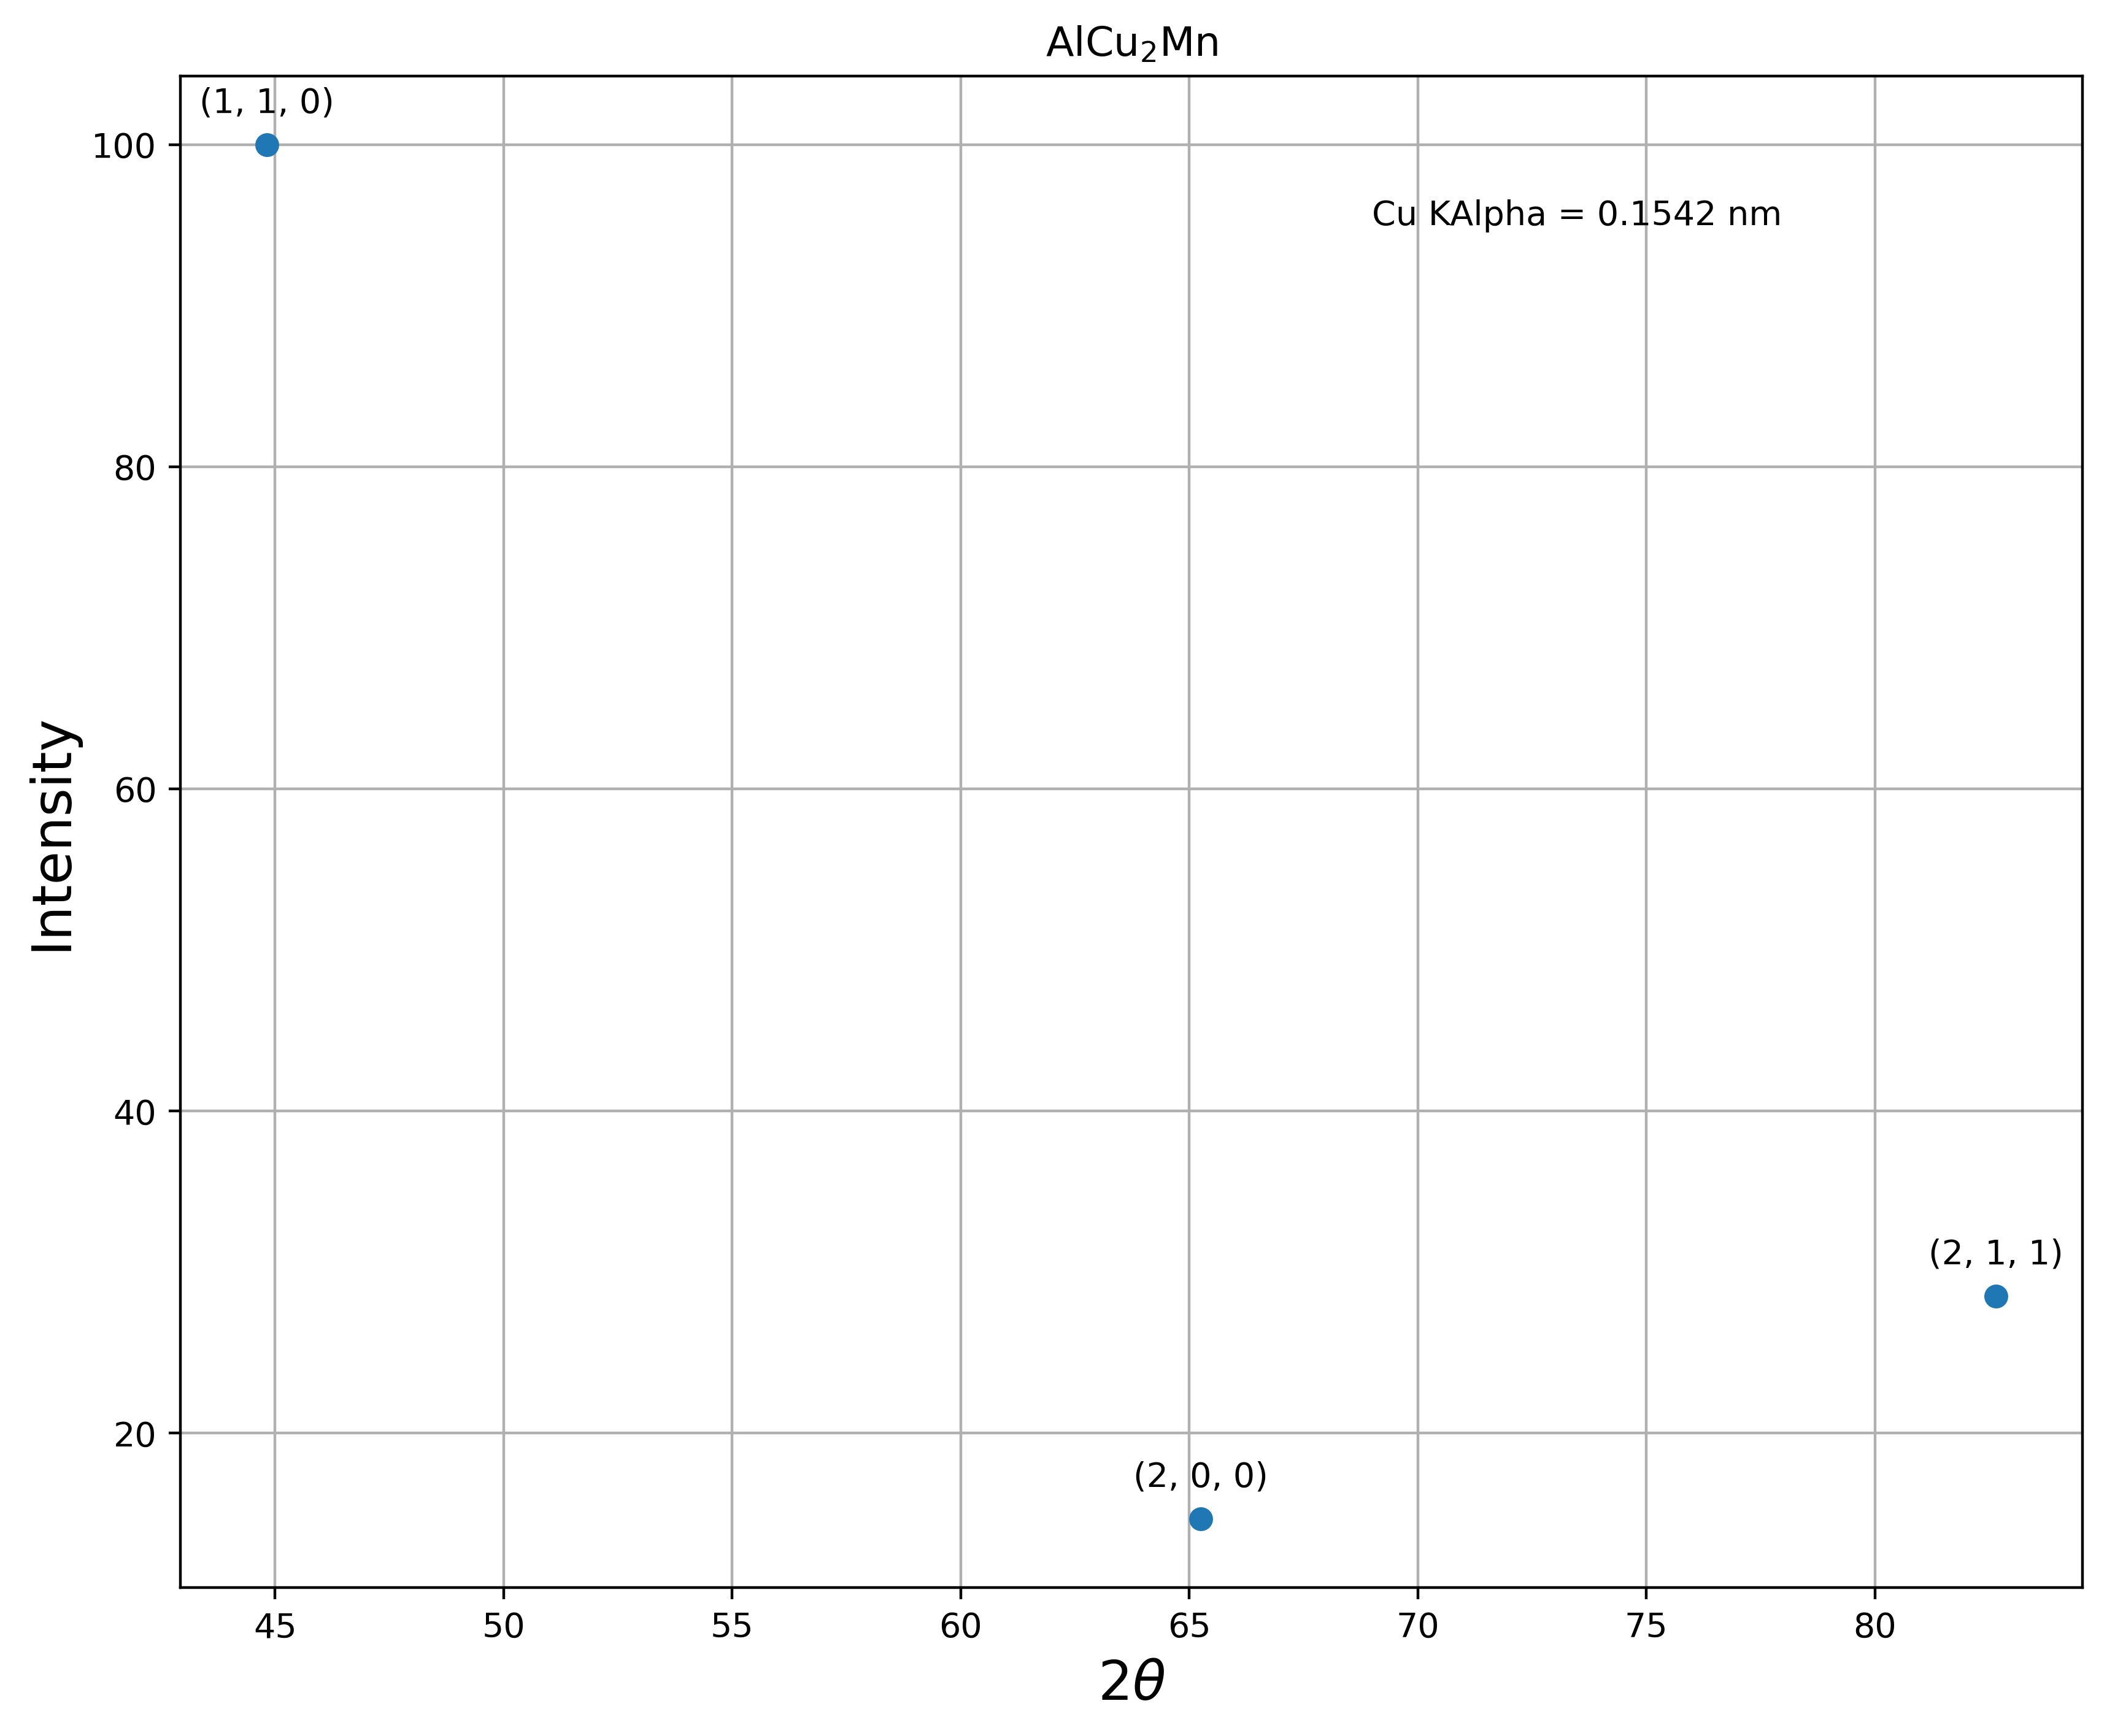

In [15]:
fig = plt.figure(figsize=(10, 8), dpi = 400)
plt.plot(df['2 theta (deg)'], df['Intensity_norm'], 'o')

# Add text labels above each data point
for index, row in df.iterrows():
    label = str(row['Miller']).replace('[', '(').replace(']', ')')
    x = row['2 theta (deg)']
    y = row['Intensity_norm']
    plt.text(x, y + 0.02 * max(df['Intensity_norm']), label, ha='center')

# Figure formatting
plt.text(69, 95, "Cu KAlpha = 0.1542 nm")
plt.xlabel("2"r'$\theta$', fontsize = 16)
plt.ylabel('Intensity', fontsize = 16)
plt.title(r'$\mathrm{AlCu_2Mn}$')
plt.grid()
plt.tight_layout
